## Simultaneous multislice SENSE/GRAPPA
###### Author: Zimu Huo
###### Date: 05.2022

First Grappa based sms recon[1] that I could find. This algorithms uses the reference data as calibration signal to train the grappa kernels in the least mean square sense, then applies the weight to the undersampled data. The grappa kernel can be used as convolution in k space or multiplication in image domain. The image domain approach is used here, but theoratically they should provide same result. 

<br>

pros:<br>
    - transform sms into 2D problem <br>
    - use conventional grappa algorithm(same as 2D)<br>
    - allows higher acceration factor, essentially capable of in plane parallel imaging <br>
    <br>
cons: <br>
    - lack of sharp changes (between slices)<br>
    - high aliasing artefact (leakage)<br>

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Blaimer M et al. 
    Title: Accelerated volumetric MRI with a SENSE/GRAPPA combination
    Link: https://onlinelibrary.wiley.com/doi/10.1002/jmri.20632
    
    [2] 
    Author: Markus Barth et al. 
    Title: Simultaneous multislice (SMS) imaging techniques
    Link: https://onlinelibrary.wiley.com/doi/10.1002/mrm.25897#mrm25897-bib-0064

In [2]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import numpy as np
from scipy import io
import util.simulator as simulate
from util.coil import *
from util.fft import *
import util.mask as undersample
from util.sensegrappa import *
from tqdm.notebook import tqdm

In [3]:
# the coil number is high, so simulation with more than 2 slices will be long 
numSlice = 4
R = 8
from util.twix import *
file_sms = "../lib/resource/data/multicoil_4slice/meas_MID00134_FID55501_catesain_4slices.dat"
file = readtwix(file_sms)
data = file[0]['readouts'][...,:numSlice]
rawImage = ifft2c(data)
fovHeight, fovWidth, numCoil, _ = rawImage.shape

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
Scan  1
100 % parsed in 1 s. Estimated 0 s remaining.
----------------------------------------------------------------------------------------------------
reading raw data, calculating trajectories and sampling raster 


  0%|          | 0/1063 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
file parsed, the scans detected in sequential order are: 
DATA
DATA
DATA
DATA
----------------------------------------------------------------------------------------------------
loading and preprocessing the data..
[' sli: 0 par: 0 rep: 0 phs: 0 dtype: DATA']
[' sli: 1 par: 0 rep: 0 phs: 0 dtype: DATA']
[' sli: 2 par: 0 rep: 0 phs: 0 dtype: DATA']
[' sli: 3 par: 0 rep: 0 phs: 0 dtype: DATA']
 sli: 0 par: 0 rep: 0 phs: 0 dtype: DATA
 sli: 1 par: 0 rep: 0 phs: 0 dtype: DATA
 sli: 2 par: 0 rep: 0 phs: 0 dtype: DATA
 sli: 3 par: 0 rep: 0 phs: 0 dtype: DATA
----------------------------------------------------------------------------------------------------
dynamically combining data according to dtype, sli, par, rep..
concat  DATA DATA 3
concat  DATA DATA 3
concat  DATA DATA 3
----------------------------------------------------------------------------------------------------
finished, the 

In [4]:
rawData= fft2c(rawImage)
acsK = simulate.acs(rawData, (32, 32))

patch taken from 112 : 144 in y
patch taken from 112 : 144 in x


In [5]:
cycle = np.arange(0,1,1/numSlice) * 2* np.pi
numAccq = int(numSlice*fovHeight/R)
shift = cycle*numAccq/(2*np.pi)

In [6]:
dataR = fft2c(simulate.multiSliceCAIPI(rawImage, cycle, R))
acsIm  = ifft2c(acsK)
acsshift = cycle*(32*4/8)/(2*np.pi)
acsImLarge = simulate.multiSliceFov(acsIm, acsshift)
acs = fft2c(acsImLarge)

In [7]:
recon = grappa(dataR, acs, 8)

processing kernel


  0%|          | 0/30 [00:00<?, ?it/s]

kernels -> weights


  0%|          | 0/8 [00:00<?, ?it/s]

applying weights


  0%|          | 0/34 [00:00<?, ?it/s]

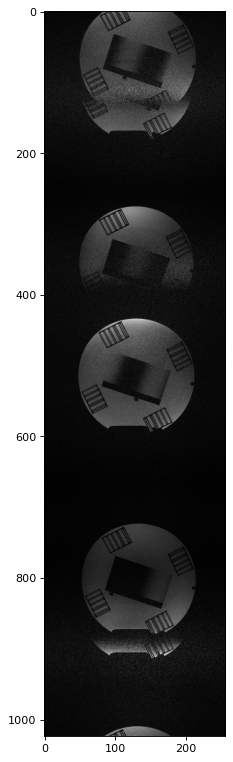

In [8]:
fig = plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(np.abs(rsos(recon)), cmap = "gray")